<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект-2: Анализ вакансий на hh.ru

In [360]:

from sqlalchemy import create_engine
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import requests 
from bs4 import BeautifulSoup


#отключаем обрезание текста в display
pd.set_option('display.max_colwidth', None)

# параметры подключения
from config import *

In [361]:
connection = create_engine(f'postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}')

# <center> Юнит 3. Предварительный анализ данных

**1)** Напишите запрос, который посчитает количество вакансий в базе (таблица **vacancies**).

In [303]:
query = f'''
SELECT
    COUNT(*) vacancies_entries,
    COUNT(name) vacancies_opened,
    COUNT(DISTINCT name) vacancies_unic
FROM
    vacancies
        '''
vac_n = pd.read_sql_query(query, connection)
display(vac_n)
print(f"Всего записей в таблице vacancies {vac_n['vacancies_entries'][0]}, пустых полей в столбце",
     f"с наименованием вакансий нет. Уникальных наименований вакансий {vac_n['vacancies_unic'][0]},",
     f"что составляет практически половину базы. Можно предположить, что названия вакансий в базе", 
     f"не унифицированы.")

,vacancies_entries,vacancies_opened,vacancies_unic
0,49197,49197,21223


Всего записей в таблице vacancies 49197, пустых полей в столбце с наименованием вакансий нет. Уникальных наименований вакансий 21223, что составляет практически половину базы. Можно предположить, что названия вакансий в базе не унифицированы.


**2)** Напишите запрос, который посчитает количество работодателей (таблица **employers**). 

In [123]:
query = f'''
SELECT
    COUNT(*) employers_entries,
    COUNT(name) employers_opened,
    COUNT(DISTINCT name) employers_unic
FROM
    employers
        '''
emp_n = pd.read_sql_query(query, connection)
display(emp_n)
print(f"Всего записей в таблице employers {emp_n['employers_entries'][0]}, пустых полей в столбце",
     f"с наименованием работодателей нет. Уникальных наименований работодателей {emp_n['employers_unic'][0]},",
     f"что составляет более {int(emp_n['employers_unic'][0]/emp_n['employers_entries'][0] * 100)}%.",
     f"Посмотрим, что означают дубли в справочнике работодателей.")
query = f'''
SELECT
    e.id first_id,
	a.id second_id,
	e.name,
	e.area first_area,
	a.area second_area
FROM
    employers e
	CROSS JOIN employers a
WHERE e.name = a.name AND e.id <> a.id
ORDER BY e.name
OFFSET 44
LIMIT 10
        '''
emp_dubl = pd.read_sql_query(query, connection)
display(emp_dubl)
print(f"Видно, что работодатели с одинаковыми наименованиями встречаются в двух, а то и в трех разных", 
      f"регионах. Посмотрим, встречаются ли в одном регионе работодатели с одинаковым наименованием:")
query = f'''
SELECT
    e.id first_id,
	a.id second_id,
	e.name,
	e.area first_area,
	a.area second_area
FROM
    employers e
	CROSS JOIN employers a
WHERE e.name = a.name AND e.id < a.id AND e.area = a.area
ORDER BY e.name
OFFSET 14
LIMIT 10
        '''
emp_dubl_reg = pd.read_sql_query(query, connection)
display(emp_dubl_reg)
print(f"Да, в одном регионе названия работодателей тоже могут повторяться, отличать их можно только по id.")

,employers_entries,employers_opened,employers_unic
0,23501,23501,23175


Всего записей в таблице employers 23501, пустых полей в столбце с наименованием работодателей нет. Уникальных наименований работодателей 23175, что составляет более 98%. Посмотрим, что означают дубли в справочнике работодателей.


,first_id,second_id,name,first_area,second_area
0,916477,2508807,Автомастер,71,1641
1,2508807,916477,Автомастер,1641,71
2,5908512,214174,Автосила,2041,26
3,214174,5908512,Автосила,26,2041
4,4556149,3385635,Агросервис,58,1
5,3070902,4556149,Агросервис,1546,58
6,3070902,3385635,Агросервис,1546,1
7,4556149,3070902,Агросервис,58,1546
8,3385635,4556149,Агросервис,1,58
9,3385635,3070902,Агросервис,1,1546


Видно, что работодатели с одинаковыми наименованиями встречаются в двух, а то и в трех разных регионах. Посмотрим, встречаются ли в одном регионе работодатели с одинаковым наименованием:


,first_id,second_id,name,first_area,second_area
0,1019812,5360841,Новые Технологии,2,2
1,1969799,5367608,Новые Технологии,1,1
2,4339988,5164580,Перспектива,1,1
3,735079,4344000,Перспектива,1,1
4,4339988,4344000,Перспектива,1,1
5,735079,4339988,Перспектива,1,1
6,4344000,5164580,Перспектива,1,1
7,735079,5164580,Перспектива,1,1
8,5713293,6005135,РОСТ,1,1
9,5001382,5950821,РСК,2,2


Да, в одном регионе названия работодателей тоже могут повторяться, отличать их можно только по id.


**3)** Посчитайте с помощью запроса количество регионов (таблица **areas**).

In [124]:
query = f'''
SELECT
    COUNT(*) areas_entries,
    COUNT(name) areas_opened,
    COUNT(DISTINCT name) areas_unic
FROM
    areas
        '''
ar_n = pd.read_sql_query(query, connection)
display(ar_n)
print(f"Все записи в таблице areas уникальны.")

,areas_entries,areas_opened,areas_unic
0,1362,1362,1362


Все записи в таблице areas уникальны.


**4)** Посчитайте с помощью запроса количество сфер деятельности в базе (таблица **industries**).

In [135]:
query = f'''
SELECT
    COUNT(*) industries_entries,
    COUNT(name) industries_opened,
    COUNT(DISTINCT name) industries_unic
FROM
    industries
        '''
ind_n = pd.read_sql_query(query, connection)
display(ind_n)
print(f"Все записи в таблице industries уникальны. Посмотрим на них:")
query = f'''
SELECT
    name
FROM
    industries
ORDER BY 1
OFFSET 20
LIMIT 10
        '''
ind_p = pd.read_sql_query(query, connection)
display(ind_p)
print(f"Видно, что формулировки формализованы, т.е. команда",
      f"сайта вакансий провела работу над созданием справочника по сферам деятельности.")

,industries_entries,industries_opened,industries_unic
0,294,294,294


Все записи в таблице industries уникальны. Посмотрим на них:


,name
0,"Безалкогольные напитки (продвижение, оптовая торговля)"
1,Безалкогольные напитки (производство)
2,"Безопасность, охранная деятельность"
3,"Бетон, кирпич, стекло и прочие силикаты (продвижение, оптовая торговля)"
4,"Бетон, кирпич, стекло и прочие силикаты (производство)"
5,Бизнес-образование
6,Благотворительная организация
7,Благоустройство и уборка территорий и зданий
8,"Ботанический сад, зоопарк, заповедник"
9,"Бытовая техника, электроника, климатическое оборудование (монтаж, сервис, ремонт)"


Видно, что формулировки формализованы, т.е. команда сайта вакансий провела работу над созданием справочника по сферам деятельности.


Итак, в базе представлены 49 тысяч вакансий, всего на сайте зарегистрировались 23 тысячи работодателей, а специалисты по рекрутингу выделили порядка 300 направлений хозяйственной деятельности.

По последним официальным данным доля лиц трудоспособного возраста составляла 56.3% населения РФ, т.е. 83 млн человек. Уровень безработицы колеблется вокруг 5% рабочей силы, т.е. в стране около 4 млн безработных. По имеющимся в базе вакансиям получится трудоустроить только 1% официально безработных.

При этом, можем ли мы сказать, что от каждого работодателя поступило, в среднем, по две вакансии? Нет, для этого нужны перекрестные запросы из таблиц, т.е. мы пока не можем утверждать, что все работодатели в базе активные (имеют размещенные вакансии). 

Так же мы пока не можем говорить о географии работодателей, т.к. в таблице areas представлены как отдельные города, так и регионы РФ, а вдобавок и другие страны. Т.е. имеем очень разную географическую детализацию в одном справочнике.

# <center> Юнит 4. Детальный анализ вакансий

**1)** Напишите запрос, который позволит узнать, сколько (cnt) **вакансий в каждом регионе** (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [352]:
query = f'''
WITH x AS
(SELECT    --Подзапрос: регион-количество вакансий          
    a.name area,
    COUNT(*) cnt
FROM
    vacancies v
	JOIN areas a ON a.id = v.area_id
GROUP BY area
ORDER BY cnt DESC)
(SELECT
    area,
	cnt
FROM x
LIMIT 5)
UNION ALL
(SELECT
    'all areas with vacancies',
	COUNT(cnt)
FROM x)
UNION ALL
(SELECT
    'with 1 vacancy',
	COUNT(cnt)
FROM x
WHERE cnt = 1)
        '''
vac_ar = pd.read_sql_query(query, connection)
display(vac_ar)
print(f"На пять регионов-лидеров приходится {vac_ar['cnt'][:5].sum()}, т.е. более",
      f"{int(vac_ar['cnt'][:5].sum()/vac_n['vacancies_entries'][0] * 100)}% вакансий.",
      f"Только в {vac_ar['cnt'][5]} из {ar_n['areas_unic'][0]} представленных территорий есть",
      f"открытые вакансии. Из них в {vac_ar['cnt'][6]} образованиях открыто только по одной вакансии.")

,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
5,all areas with vacancies,769
6,with 1 vacancy,193


На пять регионов-лидеров приходится 14194, т.е. более 28% вакансий. Только в 769 из 1362 представленных территорий есть открытые вакансии. Из них в 193 образованиях открыто только по одной вакансии.


**2)** Напишите запрос, чтобы определить у какого количества вакансий **заполнено хотя бы одно из двух полей с зарплатой**.

In [99]:
query = f'''
SELECT
    '1. both filled' fill,
    COUNT(*) cnt
FROM
    vacancies 
WHERE salary_from IS NOT NULL AND salary_to IS NOT NULL
UNION ALL
SELECT
    '2. only one filled' fill,
    COUNT(*) cnt
FROM
    vacancies 
WHERE salary_from IS NULL AND salary_to IS NOT NULL
    OR salary_from IS NOT NULL AND salary_to IS NULL
UNION ALL
SELECT
    '3. no one filled' fill,
    COUNT(*) cnt
FROM
    vacancies 
WHERE salary_from IS NULL AND salary_to IS NULL
UNION ALL
SELECT
    '4. filled with zeros',
    COUNT(*) cnt
FROM
    vacancies 
WHERE salary_from = 0 OR salary_to = 0
ORDER BY fill
        '''
var_sal = pd.read_sql_query(query, connection)
display(var_sal)
print(f"Из {var_sal['cnt'].sum()} вакансий хотя бы одно зарплатное поле заполнено у",
      f"{var_sal['cnt'][:2].sum()} вакансий.",
      f"Т.е. у более половины вакансий предложение по зарплате не указано.",
      f"Скрытых пропусков (заполненных нулями) нет.")

,fill,cnt
0,1. both filled,10102
1,2. only one filled,13971
2,3. no one filled,25124
3,4. filled with zeros,0


Из 49197 вакансий хотя бы одно зарплатное поле заполнено у 24073 вакансий. Т.е. у более половины вакансий предложение по зарплате не указано. Скрытых пропусков (заполненных нулями) нет.


**3)** Найдите **средние значения для нижней и верхней границы зарплатной вилки**. Округлите значения до целого числа.

In [100]:
query = f'''
SELECT
    'mean' agg,
	ROUND(AVG(salary_from)) salary_low,
    ROUND(AVG(salary_to)) salary_up
FROM
    vacancies
UNION ALL
SELECT
    'median',
    ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY salary_from)),
    ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY salary_to))
FROM
    vacancies
ORDER BY agg
        '''
avg_sal = pd.read_sql_query(query, connection)
display(avg_sal)
print(f"Средняя верхняя граница вилки по зарплате в {round(avg_sal['salary_up'][0]/avg_sal['salary_low'][0],1)}",
      f"раз выше средней нижней границы. Медианные показатели ниже в",
      f"{round(avg_sal['salary_up'][0]/avg_sal['salary_up'][1],1)} раза, но соотношение верхней к нижней",
      f"границе {round(avg_sal['salary_up'][1]/avg_sal['salary_low'][1],1)} сохраняется.")

,agg,salary_low,salary_up
0,mean,71065.0,110537.0
1,median,50000.0,80000.0


Средняя верхняя граница вилки по зарплате в 1.6 раз выше средней нижней границы. Медианные показатели ниже в 1.4 раза, но соотношение верхней к нижней границе 1.6 сохраняется.


**4)** Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (**schedule**) и типа трудоустройства (**employment**), используемого в вакансиях. Результат отсортируйте по убыванию количества.

In [101]:
query = f'''
SELECT
    schedule,
	employment,
    COUNT(*) cnt
FROM
    vacancies 
GROUP BY schedule, employment
ORDER BY cnt DESC
LIMIT 7
        '''
sch_emp = pd.read_sql_query(query, connection)
display(sch_emp)
print(f"Предложения работы на полный день с полной занятостью составляют",
      f"{int(sch_emp['cnt'][0]/vac_n['vacancies_entries'][0] * 100)}% всех вакансий.",
      f"Все варианты с полной занятостью вошли в ТОП-7 по количеству вакансий. Так же в числе лидеров",
      f"частичная занятость с удаленным графиком работы и стажировка на полный день. Видна растущая",
      f"популярность удаленной работы, предложения с полной или частичной занятостью составили",
      f"{int((sch_emp['cnt'][1] + sch_emp['cnt'][3])/vac_n['vacancies_entries'][0] * 100)}% вакансий.\n"
      + f"Особенно приятно отметить, что стажеры обогнали вахтовиков, т.е. запрос на тяжелый труд в",
      f"удаленных регионах ниже, чем на поиск перспективных высококвалифицированных кадров.")

,schedule,employment,cnt
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367


Предложения работы на полный день с полной занятостью составляют 71% всех вакансий. Все варианты с полной занятостью вошли в ТОП-7 по количеству вакансий. Так же в числе лидеров частичная занятость с удаленным графиком работы и стажировка на полный день. Видна растущая популярность удаленной работы, предложения с полной или частичной занятостью составили 18% вакансий.
Особенно приятно отметить, что стажеры обогнали вахтовиков, т.е. запрос на тяжелый труд в удаленных регионах ниже, чем на поиск перспективных высококвалифицированных кадров.


**5)** Напишите запрос, выводящий значения поля **требуемый опыт работы** (experience) **в порядке возрастания количества вакансий**, в которых указан данный вариант опыта. 

In [364]:
query = f'''
SELECT
    experience,
    COUNT(*) cnt,
	ROUND(COUNT(*) * 100 / (SUM(COUNT(*)) OVER()))::smallint perc
FROM
    vacancies 
GROUP BY experience
ORDER BY cnt
        '''
exp_vac = pd.read_sql_query(query, connection)
display(exp_vac)
print(f"53% предложений рассчитаны на специалистов с небольшим опытом работы, к ним",
      f"добавляются 15% вакансий от работодателей, которым нужны самые дешевые исполнители без",
      f"опыта работы. И только треть позиций подразумевают найм специалистов с опытом работы",
      f"более 3 лет, т.е. более высокую оплату за наличие ценных компетенций. Возможны",
      f"два варианта:\n - работодатели ищут высококвалифицированных специалистов по другим",
      f"источникам,\n - ситуация на рынке такова, что клиенты выбирают самые дешевые работы/"
      + f"услуги, не смотря на снижение качества, соответственно, в этих отраслях не нужны",
      f"дорогие высококвалифицированные кадры. Большой привет тендерной системе и госзаказу!")

,experience,cnt,perc
0,Более 6 лет,1337,3
1,Нет опыта,7197,15
2,От 3 до 6 лет,14511,29
3,От 1 года до 3 лет,26152,53


53% предложений рассчитаны на специалистов с небольшим опытом работы, к ним добавляются 15% вакансий от работодателей, которым нужны самые дешевые исполнители без опыта работы. И только треть позиций подразумевают найм специалистов с опытом работы более 3 лет, т.е. более высокую оплату за наличие ценных компетенций. Возможны два варианта:
 - работодатели ищут высококвалифицированных специалистов по другим источникам,
 - ситуация на рынке такова, что клиенты выбирают самые дешевые работы/услуги, не смотря на снижение качества, соответственно, в этих отраслях не нужны дорогие высококвалифицированные кадры. Большой привет тендерной системе и госзаказу!


***

Посмотрим как зависит вилка зарплат от региона. Возьмем медиану как показатель, менее зависимый от выбросов:


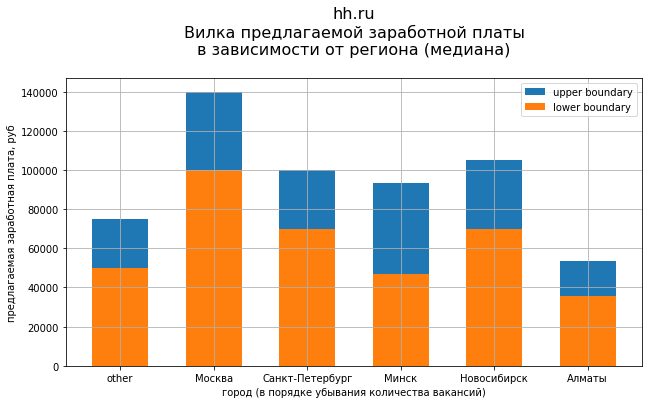

И отдельно посмотрим для Москвы разброс предлагаемой зарплаты в зависимости от опыта кандидатов:


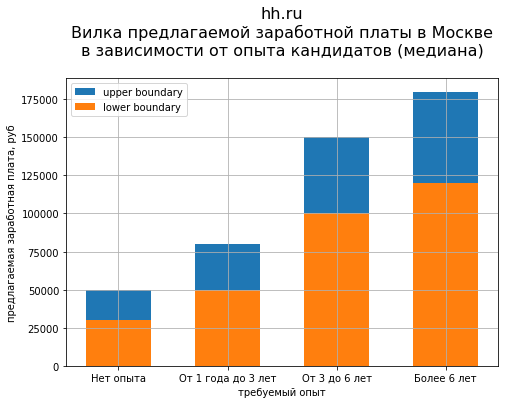

In [104]:
query = f'''
SELECT
    CASE WHEN a.name NOT IN ('Москва', 'Санкт-Петербург', 'Минск', 'Новосибирск', 'Алматы') 
         THEN 'other' ELSE a.name END area,
	COUNT(*) cnt,
    ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY salary_from)) salary_low,
    ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY salary_to)) salary_up
FROM
    vacancies v
	JOIN areas a ON a.id = v.area_id
GROUP BY area
ORDER BY cnt DESC
        '''
sal_ar = pd.read_sql_query(query, connection)
print("Посмотрим как зависит вилка зарплат от региона. Возьмем медиану как",
      f"показатель, менее зависимый от выбросов:")
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(
    sal_ar['area'],
    sal_ar['salary_up'],
    width=0.6,
    label='upper boundary'
    )
ax.bar(
    sal_ar['area'],
    sal_ar['salary_low'],
    width=0.6,
    label='lower boundary'
    )
ax.set_title(f'hh.ru\nВилка предлагаемой заработной платы\n'
               + 'в зависимости от региона (медиана)\n', 
               fontsize=16)
ax.set_xlabel('город (в порядке убывания количества вакансий)')
ax.set_ylabel('предлагаемая заработная плата, руб')
ax.legend()
ax.grid()
plt.show()

query = f'''
SELECT
    experience,
    ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY salary_from)) salary_low,
    ROUND(PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY salary_to)) salary_up
FROM
    vacancies 
GROUP BY experience
ORDER BY salary_up
        '''
exp_msc = pd.read_sql_query(query, connection)
print("И отдельно посмотрим для Москвы разброс предлагаемой зарплаты в зависимости",
      f"от опыта кандидатов:")
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(
    exp_msc['experience'],
    exp_msc['salary_up'],
    width=0.6,
    label='upper boundary'
    )
ax.bar(
    exp_msc['experience'],
    exp_msc['salary_low'],
    width=0.6,
    label='lower boundary'
    )
ax.set_title(f'hh.ru\nВилка предлагаемой заработной платы в Москве\n'
               + 'в зависимости от опыта кандидатов (медиана)\n', 
               fontsize=16)
ax.set_xlabel('требуемый опыт')
ax.set_ylabel('предлагаемая заработная плата, руб')
ax.legend()
ax.grid()
plt.show()

Видно, что в Москве нижняя планка по предлагаемой зарплате находится на уровне верхней планки трех других городов-лидеров по количеству открытых вакансий. И если верхняя планка в Новосибирске, Петербурге и Минске практически совпадает, то начинается предложение в Минске от существенно меньших уровней. В старой столице Казахстана верхняя планка по зарплате практически в два раза ниже, чем в столице Беларуси, и почти в три раза ниже, чем в Москве.

Рассматривая вилку по заработной плате в зависимости от опыта кандидатов, можем сказать, что получив опыт работы от года до трех лет, соискатель в Москве переходит из диапазона зарплат ниже 50 тысяч рублей, в диапазон, который начинается от 50 тысяч. Но наибольший качественный скачок, по мнению работодателей, происходит при опыте работы от трех до шести лет. Те, кто ищут опытные кадры, поднимают вилку предлагаемых зарплат в два раза по сравнению с предложением менее опытным кандидатам. Для привлечения еще более маститых специалистов компании рассчитывают, видимо, уже не столько на кратное увеличение зарплат, сколько на другие составляющие мотивационного пакета.

# <center> Юнит 5. Анализ работодателей

**1)** Напишите запрос, который позволит узнать, какие **работодатели** находятся на первом и пятом месте **по количеству вакансий**.

In [155]:
query = f'''
WITH x AS
(SELECT
    e.name employer,
	COUNT(*) cnt
FROM
    vacancies v
	JOIN employers e ON e.id = v.employer_id
GROUP BY employer
ORDER BY cnt DESC)
(SELECT employer, cnt FROM x
LIMIT 1)
UNION ALL
(SELECT employer, cnt FROM x
OFFSET 4
LIMIT 1)
UNION ALL
(SELECT 'всего работодателей', COUNT(*) FROM x)
        '''
emp_vac = pd.read_sql_query(query, connection)
display(emp_vac)
print(f"Всего работодателей, разместивших вакансии, {emp_vac['cnt'][2]} из",
      f"{emp_n['employers_entries'][0]} записей в таблице employers.",
      f"\nЛидер среди работодателей - Яндекс - разместил вакансий в",
      f"{round(emp_vac['cnt'][0]/emp_vac['cnt'][1])} раз больше, чем пятая компания в рейтинге.",
      f"Доля вакансий от Яндекса составляет",
      f"{round(emp_vac['cnt'][0]/vac_n['vacancies_entries'][0] * 100)}%",
      f"общего количества вакансий в базе.")

,employer,cnt
0,Яндекс,1933
1,Газпром нефть,331
2,всего работодателей,14766


Всего работодателей, разместивших вакансии, 14766 из 23501 записей в таблице employers. 
Лидер среди работодателей - Яндекс - разместил вакансий в 6 раз больше, чем пятая компания в рейтинге. Доля вакансий от Яндекса составляет 4% общего количества вакансий в базе.


**2)** Напишите запрос, который **для каждого региона** выведет количество **работодателей и вакансий** в нём.

Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.

In [220]:
query = f'''
WITH vac AS
(SELECT                         -- Подзапрос: вакансии по регионам
    a.name area,
    COUNT(v.id) vacancies
FROM
    areas a 
    LEFT JOIN vacancies v ON a.id = v.area_id
GROUP BY a.name),
emp AS
(SELECT                         -- Подзапрос: работодатели по регионам
    a.name area,
    COUNT(e.id) employers
FROM
    areas a 
    LEFT JOIN employers e ON a.id = e.area
GROUP BY a.name)
SELECT area
FROM vac JOIN emp USING(area)
WHERE vacancies = 0
ORDER BY employers DESC
LIMIT 10
        '''
ar_emp_vac = pd.read_sql_query(query, connection)
display(ar_emp_vac)
print(f"{ar_emp_vac['area'][0]} - регион с наибольшим количеством зарегистрированных работодателей,",
      f"в котором не создано вакансий.\nКак мы и опасались - большие компании-работодатели",
      f"выбирают в качестве региона регистрации более крупные единицы территориального деления:",
      f"страну, республику, край, область. В то время как вакансии размещаются с более конкретной",
      f"географической привязкой - для соискателей важно находится ли потенциальное место",
      f"работы в городе их проживания. В данной ситуации имело смысл сделать иерархический",
      f"географический справочник, чтобы соотносить более крупные и мелкие территории.")

,area
0,Россия
1,Казахстан
2,Московская область
3,Краснодарский край
4,Ростовская область
5,Беларусь
6,Азербайджан
7,Нижегородская область
8,Республика Татарстан
9,Узбекистан


Россия - регион с наибольшим количеством зарегистрированных работодателей, в котором не создано вакансий.
Как мы и опасались - большие компании-работодатели выбирают в качестве региона регистрации более крупные единицы территориального деления: страну, республику, край, область. В то время как вакансии размещаются с более конкретной географической привязкой - для соискателей важно находится ли потенциальное место работы в городе их проживания. В данной ситуации имело смысл сделать иерархический географический справочник, чтобы соотносить более крупные и мелкие территории.


**3)** Для **каждого работодателя** посчитайте **количество регионов**, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.

In [224]:
query = f'''
SELECT
    e.name employers,
    COUNT(DISTINCT a.id) areas
FROM
    employers e 
    LEFT JOIN vacancies v ON e.id = v.employer_id
	LEFT JOIN areas a ON a.id = v.area_id
GROUP BY e.name
ORDER BY areas DESC	
LIMIT 10
        '''
emp_ar = pd.read_sql_query(query, connection)
display(emp_ar)
print(f"{emp_ar['employers'][0]} лидирует не только по количеству размещенных вакансий,",
      f"но и по их географической представленности: компания открыла вакансии в",
      f"{emp_ar['areas'][0]} регионе.")

,employers,areas
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
5,Совкомбанк,63
6,МТС,55
7,"ЭФКО, Управляющая компания",49
8,Почта России,48
9,КРОН,48


Яндекс лидирует не только по количеству размещенных вакансий, но и по их географической представленности: компания открыла вакансии в 181 регионе.


**4)** Напишите запрос для подсчёта **количества работодателей**, у которых **не указана сфера деятельности**. 

In [227]:
query = f'''
SELECT COUNT(*) employers_no_industries FROM
(SELECT
    e.name employers,
    COUNT(i.industry_id) industries
FROM
    employers e 
    LEFT JOIN employers_industries i ON e.id = i.employer_id
GROUP BY e.id
HAVING COUNT(i.industry_id) = 0) employers_no_industries
        '''
emp_ind = pd.read_sql_query(query, connection)
display(emp_ind)
print(f"{emp_ind['employers_no_industries'][0]} работодателей не выбрали ни одну из",
      f"предложенных в справочнике сфер деятельности.")

,employers_no_industries
0,8419


8419 работодателей не выбрали ни одну из предложенных в справочнике сфер деятельности.


**5)** Напишите запрос, чтобы узнать **название компании**, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано **четыре сферы деятельности**.

In [230]:
query = f'''
SELECT
    e.name employers
FROM
    employers e 
    JOIN employers_industries i ON e.id = i.employer_id
GROUP BY e.id
HAVING COUNT(i.industry_id) = 4
ORDER BY employers
OFFSET 2
LIMIT 1
        '''
emp_four = pd.read_sql_query(query, connection)
display(emp_four)
print(f"Третье по алфавиту место среди работодателей, указавших четыре сферы деятельности,",
      f"занимает компания {emp_four['employers'][0]}.")

,employers
0,2ГИС


Третье по алфавиту место среди работодателей, указавших четыре сферы деятельности, занимает компания 2ГИС.


**6)** С помощью запроса выясните, у какого **количества работодателей** в качестве сферы деятельности указана **Разработка программного обеспечения**.

In [282]:
query = f'''
SELECT COUNT(*) employers_po FROM
(SELECT
    DISTINCT i.employer_id
FROM
    employers_industries i
    JOIN industries inm ON inm.id = i.industry_id 
            AND inm.name = 'Разработка программного обеспечения'
) emp_po
        '''
emp_po = pd.read_sql_query(query, connection)
display(emp_po)
print(f"{emp_po['employers_po'][0]} работодателей указали как сферу деятельности",
      f"Разработку программного обеспечения. \nТаким образом, разработкой ПО занимается",
      f"1/{round((emp_n['employers_entries'][0]-emp_ind['employers_no_industries'][0])/emp_po['employers_po'][0])}",
      f"компаний, указавших хотя бы одну сферу деятельности.")

,employers_po
0,3553


3553 работодателей указали как сферу деятельности Разработку программного обеспечения. 
Таким образом, разработкой ПО занимается 1/4 компаний, указавших хотя бы одну сферу деятельности.


**7)** Для компании **«Яндекс»** выведите список **регионов-миллионников**, в которых представлены вакансии компании, вместе с **количеством вакансий** в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

[Список городов-милионников](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

In [247]:
#Для упрощения поиска обратимся не к самой статье Википедии, 
# а к примененному в ней шаблону:
req = requests.get('https://ru.wikipedia.org/wiki/%D0%A8%D0%B0%D0%B1%D0%BB%D0%BE%D0%BD:%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8')
print("получен ответ", req.status_code == 200)
wiki = BeautifulSoup(req.text, 'html.parser')
cities = set()
navcont = wiki.find('div', class_='NavContent')
for a in navcont.find_all('a'):
    cities.add(a.text)
print(cities)

получен ответ True
{'Казань', 'Красноярск', 'Уфа', 'Екатеринбург', 'Санкт-Петербург', 'Самара', 'Ростов-на-Дону', 'Челябинск', 'Краснодар', 'Омск', 'Воронеж', 'Волгоград', 'Новосибирск', 'Москва', 'Нижний Новгород', 'Пермь'}


In [284]:
query = f'''
WITH ya AS (SELECT id FROM employers WHERE name='Яндекс'),  -- id Яндекса
cities AS (SELECT id, name FROM areas                       -- id городов-миллионников
		   WHERE name IN {tuple(_ for _ in cities)}),   -- Передаем полученное множество через итератор
vac AS (SELECT                   -- Подзапрос: количество вакансий в городах с предложениями от Яндекса
    c.name cities,
    COUNT(v.id)::int vacancies
FROM
    vacancies v 
	JOIN ya ON ya.id = v.employer_id
    JOIN cities c ON c.id = v.area_id
GROUP BY c.name
ORDER BY vacancies)
SELECT * FROM vac
UNION ALL
SELECT 'Total', SUM(vacancies) FROM vac
UNION ALL
SELECT 'Mean', SUM(vacancies)/COUNT(*) FROM vac
        '''
ya_vac = pd.read_sql_query(query, connection)
display(ya_vac)
print(f"Всего из {emp_vac['cnt'][0]} вакансий от Яндекса",
      f"{ya_vac[ya_vac['cities'] == 'Total']['vacancies'].sum()}, то есть",
      f"1/{round(emp_vac['cnt'][0]/ya_vac[ya_vac['cities'] == 'Total']['vacancies'].sum())},",
      f"размещены в городах-миллионниках. В среднем на каждый город-миллионник приходится по",
      f"{ya_vac[ya_vac['cities'] == 'Mean']['vacancies'].sum()} вакансий от Яндекса.")

,cities,vacancies
0,Омск,21
1,Челябинск,22
2,Красноярск,23
3,Волгоград,24
4,Пермь,25
5,Казань,25
6,Ростов-на-Дону,25
7,Уфа,26
8,Самара,26
9,Краснодар,30


Всего из 1933 вакансий от Яндекса 485, то есть 1/4, размещены в городах-миллионниках. В среднем на каждый город-миллионник приходится по 30 вакансий от Яндекса.


***

In [366]:
print("Посмотрим как относятся к удаленной работе компании, указавшие среди видов",
      f"деятельности Разработку программного обеспечения:")
query = f'''
WITH emp_po AS
(SELECT                          -- Подзапрос: id поставщиков, указавших разработку ПО
    DISTINCT i.employer_id id
FROM
    employers_industries i
    JOIN industries inm ON inm.id = i.industry_id 
            AND inm.name = 'Разработка программного обеспечения'), 
sch AS (SELECT                   -- Подзапрос: тип занятости в вакансиях разработчиков ПО
    v.schedule schedule
FROM
    vacancies v 
	JOIN emp_po po ON po.id = v.employer_id)
SELECT
    'Удаленная работа' schedule,
	COUNT(*) cnt
FROM sch
WHERE schedule = 'Удаленная работа'
UNION ALL
SELECT
    'Классические виды занятости' schedule,
	COUNT(*) cnt
FROM sch
WHERE schedule <> 'Удаленная работа'
UNION ALL
SELECT
    'Удаленная работа всего' schedule,
	COUNT(*) cnt
FROM vacancies
WHERE schedule = 'Удаленная работа'
        '''
rem_po = pd.read_sql_query(query, connection)
display(rem_po)
print(f"Из всех {rem_po['cnt'][2]} предложений удаленной работы {rem_po['cnt'][0]}, т.е.",
      f"треть, приходится на вакансии компаний, занимающихся Разработкой программного",
      f"обеспечения.\nПри этом сами Разработчики ПО размещают в три раза больше вакансий",
      f"с классическими видами 'присутствия на работе' - {rem_po['cnt'][1]}, чем",
      f"предложения работать удаленно.\n\nПосмотрим какие еще сферы деятельности указали",
      f"компании, выбравшие Разработку программного обеспечения как одно из направлений:")
query = f'''
WITH emp_po AS (SELECT
    DISTINCT i.employer_id id
FROM
    employers_industries i
    JOIN industries inm ON inm.id = i.industry_id 
            AND inm.name = 'Разработка программного обеспечения')	
SELECT
    COUNT(*) cnt,
    inm.name industry
FROM
    industries inm
	JOIN employers_industries i ON inm.id = i.industry_id
	JOIN emp_po e ON e.id = i.employer_id 
GROUP BY inm.name
ORDER BY cnt DESC
LIMIT 7
        '''
po_oth = pd.read_sql_query(query, connection)
display(po_oth)
print(f"Выделяются вторая и третья позиции, которые перекрываются с разработкой ПО наполовину",
      f"и на четверть. Другие направления деятельности из верхней части таблицы, хоть и",
      f"показывают существенно меньше совпадений, также являются логичными параллельными",
      f"видами деятельности.\nИнтересно, что банки занимают только 19-е место и имеют всего",
      f"22 совпадения, хотя в современной России конкуренция заставляет все банки развивать",
      f"ИТ-направление.",
      f"\nЗато ближе к концу списка встречаются совсем неожиданные смежные отрасли, такие как",
      f"Такси, Мясная и Молочная продукция. Видимо, эти работодатели указывали разработку ПО",
      f"при размещении вакансии на должность местного ИТ-специалиста, т.е. имели ввиду",
      f"программирование не для клиентов, а для внутреннего потребления.")

Посмотрим как относятся к удаленной работе компании, указавшие среди видов деятельности Разработку программного обеспечения:


,schedule,cnt
0,Удаленная работа,3068
1,Классические виды занятости,9431
2,Удаленная работа всего,9311


Из всех 9311 предложений удаленной работы 3068, т.е. треть, приходится на вакансии компаний, занимающихся Разработкой программного обеспечения.
При этом сами Разработчики ПО размещают в три раза больше вакансий с классическими видами 'присутствия на работе' - 9431, чем предложения работать удаленно.

Посмотрим какие еще сферы деятельности указали компании, выбравшие Разработку программного обеспечения как одно из направлений:


,cnt,industry
0,3553,Разработка программного обеспечения
1,1775,"Системная интеграция, автоматизации технологических и бизнес-процессов предприятия, ИТ-консалтинг"
2,845,"Интернет-компания (поисковики, платежные системы, соц.сети, информационно-познавательные и развлекательные ресурсы, продвижение сайтов и прочее)"
3,204,Консалтинговые услуги
4,189,"Маркетинговые, рекламные, BTL, дизайнерские, Event-, PR-агентства, организация выставок"
5,93,"Электронно-вычислительная, оптическая, контрольно-измерительная техника, радиоэлектроника, автоматика (производство)"
6,66,"Производство мультимедиа, контента, редакторская деятельность"


Выделяются вторая и третья позиции, которые перекрываются с разработкой ПО наполовину и на четверть. Другие направления деятельности из верхней части таблицы, хоть и показывают существенно меньше совпадений, также являются логичными параллельными видами деятельности.
Интересно, что банки занимают только 19-е место и имеют всего 22 совпадения, хотя в современной России конкуренция заставляет все банки развивать ИТ-направление. 
Зато ближе к концу списка встречаются совсем неожиданные смежные отрасли, такие как Такси, Мясная и Молочная продукция. Видимо, эти работодатели указывали разработку ПО при размещении вакансии на должность местного ИТ-специалиста, т.е. имели ввиду программирование не для клиентов, а для внутреннего потребления.


# <center>Юнит 6. Предметный анализ

**1)** Сколько **вакансий имеет отношение к данным**?

(в названии вакансии содержится 'data' или 'данн')

In [281]:
query = f'''
SELECT
    COUNT(v.name) vacancies
FROM
    vacancies v 
WHERE lower(v.name) LIKE '%%data%%' OR lower(v.name) LIKE '%%данн%%'
        '''
vac_dt = pd.read_sql_query(query, connection)
display(vac_dt)
print(f"{vac_dt['vacancies'][0]} вакансий имеет отношение к данным. Это",
      f"{round(vac_dt['vacancies'][0]/vac_n['vacancies_entries'][0] * 100)}%",
      f"общего числа вакансий в базе.")

,vacancies
0,1771


1771 вакансий имеет отношение к данным. Это 4% общего числа вакансий в базе.


**2)** Сколько есть подходящих **вакансий** для **начинающего дата-сайентиста**? 
Вакансии для дата-сайентистов содержат в названии хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

Вакансии для специалистов уровня Junior:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.

In [314]:
query = f'''
SELECT
    COUNT(*)
FROM
    vacancies	
WHERE (lower(name) LIKE '%%data scien%%'
    OR lower(name) LIKE '%%исследователь данных%%'
    OR name LIKE '%%ML%%' AND name NOT LIKE '%%HTML%%'
    OR lower(name) LIKE '%%machine learning%%' 
    OR lower(name) LIKE '%%машинн%%обучен%%') AND
    (lower(name) LIKE '%%junior%%'
    OR experience = 'Нет опыта'
    OR employment = 'Стажировка')
        '''
ds_jun = pd.read_sql_query(query, connection)
display(ds_jun)
print(f"{ds_jun['count'][0]} вакансии подходят для начинающего дата-сайентиста, но",
      f"в написании одной из вакансий есть опечатка: Sciencist вместо Scientist.")

,count
0,52


52 вакансии подходят для начинающего дата-сайентиста, но в написании одной из вакансий есть опечатка: Sciencist вместо Scientist.


В нашем случае, когда мы хотим просто посмотреть на то как устроены интересные для нас данные, не имеет большого значения, если поиск по запросу пропустит одну-две записи. В случае, когда необходимо строго разделить все данные по категориям, можно применить следующий алгоритм: сначала использовать простые шаблоны, тем самым категоризировав большую часть записей. К оставшейся части записей применить более сложные шаблоны (например, учитывающие, что слова могут идти не подряд, другие формы слов, пропуски букв, опечатки в 2-3 буквы и т.д.). Чем короче будет оставшийся некатегоризированным список, тем проще будет подбирать алгоритмы для дальнейшей обработки.

**3)** Сколько есть **вакансий для DS**, в которых в качестве ключевого навыка указан **SQL** или **postgres**?

In [329]:
query = f'''
(SELECT
    'SQL & postgres' cat,
    COUNT(*) cnt
FROM
    vacancies	
WHERE (lower(name) LIKE '%%data scien%%'
    OR lower(name) LIKE '%%исследователь данных%%'
    OR name LIKE '%%ML%%' AND name NOT LIKE '%%HTML%%'
    OR lower(name) LIKE '%%machine learning%%' 
    OR lower(name) LIKE '%%машинн%%обучен%%') AND
    (lower(key_skills) LIKE '%%postgres%%'
    OR key_skills LIKE '%%SQL%%'))
UNION ALL
(SELECT
    'all DS',
    COUNT(*)
FROM
    vacancies	
WHERE (lower(name) LIKE '%%data scien%%'
    OR lower(name) LIKE '%%исследователь данных%%'
    OR name LIKE '%%ML%%' AND name NOT LIKE '%%HTML%%'
    OR lower(name) LIKE '%%machine learning%%' 
    OR lower(name) LIKE '%%машинн%%обучен%%'))
        '''
ds_sql = pd.read_sql_query(query, connection)
display(ds_sql)
print(f"В {ds_sql[ds_sql['cat'] == 'SQL & postgres']['cnt'].sum()} вакансии дата-сайентиста",
      f"есть требование SQL или postgres. Всего в базе",
      f"{ds_sql[ds_sql['cat'] == 'all DS']['cnt'].sum()} вакансии DS, т.е. работа с реляционными",
      f"базами данных нужна в",
      f"{round(ds_sql[ds_sql['cat'] == 'SQL & postgres']['cnt'].sum()/ds_sql[ds_sql['cat'] == 'all DS']['cnt'].sum() * 100)}% случаев.")

,cat,cnt
0,all DS,482
1,SQL & postgres,201


В 201 вакансии дата-сайентиста есть требование SQL или postgres. Всего в базе 482 вакансии DS, т.е. работа с реляционными базами данных нужна в 42% случаев.


**4)** Проверьте, насколько популярен Python в требованиях работодателей к DS. Для этого вычислите **количество вакансий**, в которых в качестве ключевого навыка указан **Python**.

In [334]:
query = f'''
SELECT
    'Python' cat,
    COUNT(*) cnt
FROM
    vacancies	
WHERE (lower(name) LIKE '%%data scien%%'
    OR lower(name) LIKE '%%исследователь данных%%'
    OR name LIKE '%%ML%%' AND name NOT LIKE '%%HTML%%'
    OR lower(name) LIKE '%%machine learning%%' 
    OR lower(name) LIKE '%%машинн%%обучен%%') AND
    (lower(key_skills) LIKE '%%python%%')
        '''
ds_py = pd.read_sql_query(query, connection)
display(ds_py)
print(f"В {ds_py[ds_py['cat'] == 'Python']['cnt'].sum()} вакансиях дата-сайентиста",
      f"необходим Python. Это еще более востребованный skill, он нужен в",
      f"{round(ds_py[ds_py['cat'] == 'Python']['cnt'].sum()/ds_sql[ds_sql['cat'] == 'all DS']['cnt'].sum() * 100)}% случаев.")

,cat,cnt
0,Python,352


В 352 вакансиях дата-сайентиста необходим Python. Это еще более востребованный skill, он нужен в 73% случаев.


**5)** Сколько **ключевых навыков** в среднем указывают в **вакансиях для DS**?
Ответ округлите до двух знаков после точки-разделителя.

In [345]:
query = f'''
SELECT
    COUNT(*) skill,
    COUNT(DISTINCT id) vacancy,
    ROUND(COUNT(*)::numeric / COUNT(DISTINCT id), 2) avg
FROM
(SELECT                  -- Подзапрос: id вакансий с key_skills, разделенными по табуляции 
    id,
	regexp_split_to_table(key_skills, CHR(9)) skill
FROM
    vacancies	
WHERE (lower(name) LIKE '%%data scientist%%'
	OR lower(name) LIKE '%%data science%%'
    OR lower(name) LIKE '%%исследователь данных%%'
    OR name LIKE '%%ML%%' AND name NOT LIKE '%%HTML%%'
    OR lower(name) LIKE '%%machine learning%%' 
    OR lower(name) LIKE '%%машинн%%обучен%%')
	AND key_skills IS NOT NULL
) skills
        '''
ds_skl = pd.read_sql_query(query, connection)
display(ds_skl)
print(f"В {ds_skl['vacancy'][0]} вакансии дата-сайентиста, где заполнена информация в поле",
      f"key_skills, всего перечисляется {ds_skl['skill'][0]} ключевых навыков, т.е.",
      f"в среднем {ds_skl['avg'][0]} на вакансию.")

,skill,vacancy,avg
0,2761,431,6.41


В 431 вакансии дата-сайентиста, где заполнена информация в поле key_skills, всего перечисляется 2761 ключевых навыков, т.е. в среднем 6.41 на вакансию.


**6)** Напишите запрос, позволяющий вычислить, какую **зарплату для DS** в среднем указывают для каждого типа требуемого опыта (уникальное значение из поля **experience**). 

1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, заменяем его на ноль.

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [350]:
query = f'''
SELECT
    experience,
	AVG(CASE WHEN salary_from IS NULL THEN salary_to
	     WHEN salary_to IS NULL THEN salary_from
		 ELSE (salary_from + salary_to)/2
        END)::integer
FROM
    vacancies	
WHERE (lower(name) LIKE '%%data scientist%%'
	OR lower(name) LIKE '%%data science%%'
    OR lower(name) LIKE '%%исследователь данных%%'
    OR name LIKE '%%ML%%' AND name NOT LIKE '%%HTML%%'
    OR lower(name) LIKE '%%machine learning%%' 
    OR lower(name) LIKE '%%машинн%%обучен%%')
	AND (salary_from IS NOT NULL
    OR salary_to IS NOT NULL)
GROUP BY experience
        '''
ds_exp = pd.read_sql_query(query, connection)
display(ds_exp)
print(f"В среднем дата-сайентисту с опытом работы от 3 до 6 лет компании готовы",
      f"предложить {ds_exp[ds_exp['experience'] == 'От 3 до 6 лет']['avg'].sum()}",
      f"рублей.\nОбратим внимание, что для суперспециалистов с опытом работы более",
      f"6 лет ориентиры по зарплате не проставлены ни в одной вакансии, т.к. к",
      f"специалистам такого уровня подход индивидуальный.")

,experience,avg
0,Нет опыта,74643
1,От 1 года до 3 лет,139675
2,От 3 до 6 лет,243115


В среднем дата-сайентисту с опытом работы от 3 до 6 лет компании готовы предложить 243115 рублей.
Обратим внимание, что для суперспециалистов с опытом работы более 6 лет ориентиры по зарплате не проставлены ни в одной вакансии, т.к. к специалистам такого уровня подход индивидуальный.


***

In [301]:
print(f"Посмотрим на распределение вакансий по специальностям у",
      f"самого крупного работодателя - Яндекса. Для этого введем несколько агрегированных",
      f"групп: поддержка, тестировщик, разработчик, аналитик, инженер, - и посчитаем",
      f"общее количество вакансий в группе и сколько запросов в среднем приходится на",
      f"каждую конкретную вакансию в группе.")
query = f'''
WITH ya AS (SELECT id FROM employers WHERE name='Яндекс'),
vac AS (SELECT
    v.name vacancy,
    COUNT(*) cnt
FROM
    vacancies v
	JOIN ya ON ya.id = employer_id
GROUP BY v.name)
SELECT
    'поддержка' vacancy,
    SUM(cnt)::int sum,
	AVG(cnt)::int mean
FROM
    vac
WHERE lower(vacancy) LIKE '%%поддерж%%'
    OR lower(vacancy) LIKE '%%клиент%%'
    OR lower(vacancy) LIKE '%%менедж%%'
UNION ALL
SELECT
    'разработчик' vacancy,
    SUM(cnt)::int,
	AVG(cnt)::int
FROM
    vac
WHERE lower(vacancy) NOT LIKE '%%поддерж%%'
    AND lower(vacancy) NOT LIKE '%%клиент%%'
    AND lower(vacancy) NOT LIKE '%%менедж%%'
	AND lower(vacancy) LIKE '%%разраб%%'
UNION ALL
SELECT
    'тестировщик' vacancy,
    SUM(cnt)::int,
	AVG(cnt)::int
FROM
    vac
WHERE lower(vacancy) NOT LIKE '%%поддерж%%'
    AND lower(vacancy) NOT LIKE '%%клиент%%'
    AND lower(vacancy) NOT LIKE '%%менедж%%'
    AND lower(vacancy) NOT LIKE '%%разраб%%'
	AND lower(vacancy) LIKE '%%тестир%%'
UNION ALL
SELECT
    'инженер' vacancy,
    SUM(cnt)::int,
	AVG(cnt)::int
FROM
    vac
WHERE lower(vacancy) NOT LIKE '%%поддерж%%'
    AND lower(vacancy) NOT LIKE '%%клиент%%'
    AND lower(vacancy) NOT LIKE '%%менедж%%'
    AND lower(vacancy) NOT LIKE '%%разраб%%'
    AND lower(vacancy) NOT LIKE '%%тестир%%'
    AND lower(vacancy) LIKE '%%инженер%%'
UNION ALL
SELECT
    'аналитик' vacancy,
    SUM(cnt)::int,
	AVG(cnt)::int
FROM
    vac
WHERE lower(vacancy) NOT LIKE '%%поддерж%%'
    AND lower(vacancy) NOT LIKE '%%клиент%%'
    AND lower(vacancy) NOT LIKE '%%менедж%%'
    AND lower(vacancy) NOT LIKE '%%разраб%%'
    AND lower(vacancy) NOT LIKE '%%тестир%%'
    AND lower(vacancy) NOT LIKE '%%инженер%%'
    AND (lower(vacancy) LIKE '%%анали%%'
    OR lower(vacancy) LIKE '%%analy%%')
UNION ALL
SELECT
    vacancy,
    SUM(cnt)::int,
	AVG(cnt)::int
FROM
    vac
WHERE lower(vacancy) NOT LIKE '%%поддерж%%'
    AND lower(vacancy) NOT LIKE '%%клиент%%'
    AND lower(vacancy) NOT LIKE '%%менедж%%'
    AND lower(vacancy) NOT LIKE '%%разраб%%'
	AND lower(vacancy) NOT LIKE '%%тестир%%'
	AND lower(vacancy) NOT LIKE '%%инженер%%'
	AND lower(vacancy) NOT LIKE '%%анали%%'
	AND lower(vacancy) NOT LIKE '%%analy%%'
GROUP BY vacancy
ORDER BY sum DESC
        '''
ya_anal = pd.read_sql_query(query, connection)
display(ya_anal)
support = ['поддержка', 'Эксперт по ответам на вопросы о Яндекс Бизнесе']
print(f"Из {emp_vac['cnt'][0]} вакансий, размещенных Яндексом,",
      f"{ya_anal[ya_anal['vacancy'].isin(support)]['sum'].sum()} приходится на группу",
      f"поддержки клиентов (собственно поддержка + эксперт по ответам).",
      f"Судя по среднему количеству запросов по каждому виду вакансий в группе",
      f"поддержки - это набор на массовые стандартизированные специальности.\n",
      f"Соответственно, на усиление команды, создающей продукт, приходится только",
      f"{round((emp_vac['cnt'][0] - ya_anal[ya_anal['vacancy'].isin(support)]['sum'].sum())/emp_vac['cnt'][0] * 100)}%",
      f"общего количества размещенных вакансий. Сюда входят различные узконаправленные",
      f"специальности, массовыми специальностями в этой группе можно назвать",
      f"тестировщиков и технических писателей.")

Посмотрим на распределение вакансий по специальностям у самого крупного работодателя - Яндекса. Для этого введем несколько агрегированных групп: поддержка, тестировщик, разработчик, аналитик, инженер, - и посчитаем общее количество вакансий в группе и сколько запросов в среднем приходится на каждую конкретную вакансию в группе.


,vacancy,sum,mean
0,поддержка,1437,27
1,тестировщик,190,24
2,разработчик,122,4
3,Технический писатель (дистанционный автор),99,99
4,Эксперт по ответам на вопросы о Яндекс Бизнесе,36,36
5,аналитик,19,1
6,инженер,11,1
7,Маркетолог in-app коммуникаций в Яндекс Доставку,7,7
8,Координатор отдела,5,5
9,Data Scientist,1,1


Из 1933 вакансий, размещенных Яндексом, 1473 приходится на группу поддержки клиентов (собственно поддержка + эксперт по ответам). Судя по среднему количеству запросов по каждому виду вакансий в группе поддержки - это набор на массовые стандартизированные специальности. Соответственно, на усиление команды, создающей продукт, приходится только 24% общего количества размещенных вакансий. Сюда входят различные узконаправленные специальности, массовыми среди них можно назвать тестировщиков и технических писателей.


# <center>Общий вывод по проекту

Видим, что Яндексу - одной из крупнейших ИТ-компаний РФ - требуется только один дата-сайентист.

Посмотрим, в каких городах работодатели ждут дата-сайентистов.

In [356]:
query = f'''
SELECT
    a.name area,
    COUNT(*) cnt,
	COUNT(DISTINCT employer_id) empl
FROM
    vacancies v	
JOIN
	areas a ON a.id = v.area_id
WHERE (lower(v.name) LIKE '%%data scien%%'
    OR lower(v.name) LIKE '%%исследователь данных%%'
    OR v.name LIKE '%%ML%%' AND v.name NOT LIKE '%%HTML%%'
    OR lower(v.name) LIKE '%%machine learning%%' 
    OR lower(v.name) LIKE '%%машинн%%обучен%%')
GROUP BY a.name 
ORDER BY cnt DESC
LIMIT 10
        '''
ds_ar = pd.read_sql_query(query, connection)
display(ds_ar)

,area,cnt,empl
0,Москва,217,130
1,Санкт-Петербург,64,47
2,Новосибирск,23,17
3,Нижний Новгород,20,9
4,Алматы,17,12
5,Казань,16,13
6,Минск,9,9
7,Томск,8,6
8,Екатеринбург,7,6
9,Армения,6,3


В топ регионов вошла пятерка городов-лидеров по общему количеству размещенных вакансий. Их разбавили Нижний Новгород и Казань. Но если общее количество вакансий в Москве в 2-2.5 раза превышало количество вакансий других городов-лидеров, то запрос на Data Science в Москве в 3 раза выше чем в Петербурге и уже в 10 раз выше, чем в Новосибирске, Нижнем Новгороде, Алматы. То есть такое новое направление деятельности как Data Science уже начало распространяться в наукоемких регионах, но пока большая его часть сконцентрирована в Москве.

Судя по количеству работодателей, разместивших вакансии дата-сайентистов, на каждого работодателя в среднем приходится по 1-2 размещенных вакансии.

Посмотрим, какие направления деятельности указали эти компании.

In [359]:
query = f'''
WITH ind AS
(SELECT             -- Подзапрос: наименования сфер деятельности работодателей дата-сайентистов
    i.name industry
FROM
    vacancies v	
JOIN
	employers_industries e ON e.employer_id = v.employer_id
JOIN
    industries i ON i.id = e.industry_id
WHERE (lower(v.name) LIKE '%%data scien%%'
    OR lower(v.name) LIKE '%%исследователь данных%%'
    OR v.name LIKE '%%ML%%' AND v.name NOT LIKE '%%HTML%%'
    OR lower(v.name) LIKE '%%machine learning%%' 
    OR lower(v.name) LIKE '%%машинн%%обучен%%'))
(SELECT
    COUNT(*) cnt,
    industry
FROM
    ind
GROUP BY industry 
ORDER BY cnt DESC
LIMIT 10)
UNION ALL
SELECT COUNT(DISTINCT industry), 'All industries' FROM ind
        '''
ds_ind = pd.read_sql_query(query, connection)
display(ds_ind)

,cnt,industry
0,149,Разработка программного обеспечения
1,140,"Системная интеграция, автоматизации технологических и бизнес-процессов предприятия, ИТ-консалтинг"
2,92,Банк
3,79,"Интернет-компания (поисковики, платежные системы, соц.сети, информационно-познавательные и развлекательные ресурсы, продвижение сайтов и прочее)"
4,23,Мобильная связь
5,22,"Маркетинговые, рекламные, BTL, дизайнерские, Event-, PR-агентства, организация выставок"
6,21,"Управляющая, инвестиционная компания (управление активами)"
7,16,Консалтинговые услуги
8,13,Фиксированная связь
9,9,"Научно-исследовательская, научная, академическая деятельность"


По направлениям деятельности компаний, использующих технологии Data Science, лидируют ИТ-компании, банки. Раз в пять отстают телекоммуникации и инвестиции/консалтинг. Пока нет такого же масштабного запроса на дата-сайентистов в научных исследованиях.

Вообще круг интересов компаний, желающих нанять дата-сайентиста, достаточно широк: треть - 98 из 294 - направлений деятельности попали в наш запрос.

В заключение отметим, что у Data Science большие перспективы, как видим, еще не все регионы и не все сферы деятельности готовы получать синергетический эффект от применения высоких технологий. Пока в наш запрос по DS не попали Такси, Мясная и Молочная продукция.

In [367]:
connection.connect().close()